# Contamination from 3b + not loose

**Goal:** Get the $$$ plots that Max and Rafael requested.

1. S / \sqrt{B}
2. S / B


- with respect to 3b + 1 loose and 4b
- and maybe w/r.t. 4b VR


So at this point, we've *already* decided that we're going to use the min_dR alg, so just **load in** these samples that Sean has already trained. :-)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from utils import mcToYr
from analysis import getXhh,getRegions

#from postprocess import significance

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
x1,y1 = 124,117

In [3]:
# Load in the signal (from me)
sdf = pd.read_parquet('../data/SMNR_mc16d-JUN20/df_min_dR1_Db_sort_VEC.parquet')

Db_cols = ['Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2']
sdf['minQ'] = np.min(sdf[Db_cols].values,axis=1)

getRegions(sdf,x1, y1, kr='kr_new')

smask = (sdf.ntag >= 3) & (sdf.bucket != 0) & (sdf.abs_deta_hh < 1.5) & (sdf.X_wt > 1.5) & (sdf.kr_new <= 2)
sdf = sdf[smask]

In [4]:
np.unique(sdf.kr_new)

array([0, 1, 2])

In [5]:
def getBkg(filename,yr):
    '''
    Given the uproot file name, *load in* the corresponding bkg SR
    '''
    
    f = uproot.open(filename)
    
    dfs = []
      
    if '4b' in filename:
        rw_col = 'rw_to_4b'
    elif '3b1l' in filename:
        rw_col = 'rw_to_3b1l'
    elif '3b1nl' in filename:
        rw_col = 'rw_to_3b1nl'
    else:
        print('Don\'t know what col to rw to for',filename)
        raise NotImplementedError
       
    try:
        norm = f[f'NN_norm_bstrap_med_{yr}']._fVal
        norm_VR = f[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal
    except:
        norm = f[f'NN_norm_bstrap_med_{yr}'].all_members['fVal']
        norm_VR = f[f'NN_norm_VRderiv_bstrap_med_{yr}'].all_members['fVal']
    
    bcols = [   'ntag', 'cosThetaStar', 'm_h1','m_h2',
                'kinematic_region', 'm_hh',  'chosenPair', 'HT', 'X_wt',
                'abs_deta_hh', 'Xhh', 'HT_all', 'lead_pt', 'lead_tag', 'bucket',
                'Db_h1_j1', 'Db_h1_j2', 'Db_h2_j1', 'Db_h2_j2', 
                'njets',  rw_col,
                'NN_d24_weight_bstrap_med_17', 'NN_d24_weight_bstrap_perc_25_17',
                'NN_d24_weight_bstrap_perc_75_17', 'NN_d24_weight_bstrap_IQR_17',
                'NN_d24_weight_VRderiv_bstrap_med_17',
                'NN_d24_weight_VRderiv_bstrap_perc_25_17',
                'NN_d24_weight_VRderiv_bstrap_perc_75_17',
                'NN_d24_weight_VRderiv_bstrap_IQR_17'
            ]
    
    
    for t in ['sig','validation','control']:
        
        try:
            dfi = f[t].pandas.df(bcols)
        except:
            dfi = f[t].arrays(bcols,library='pd')
            
        # Calculate new cols
        getRegions(dfi, x1, y1, kr='kr_new')

        dfi['minQ'] = np.min(dfi[Db_cols].values,axis=1)
        
        print(np.min(dfi[f'NN_d24_weight_bstrap_med_{yr}']),np.max(dfi[f'NN_d24_weight_bstrap_med_{yr}']))
        
        dfi['w_2b'] = norm * dfi[f'NN_d24_weight_bstrap_med_{yr}']
        dfi['w_2b_VR'] =norm_VR * dfi[f'NN_d24_weight_VRderiv_bstrap_med_{yr}']

        if rw_col == 'rw_to_4b':
            mi = dfi.ntag >= 4
        elif rw_col == 'rw_to_3b1l':
            mi = (dfi.ntag == 3) & (dfi.minQ == 2)
        elif rw_col == 'rw_to_3b1nl':
            mi = (dfi.ntag == 3) & (dfi.minQ == 1)
        else:
            raise NotImplementedError
    
        mask = (mi | dfi[rw_col]) & (dfi.kr_new <= 1) & (dfi.X_wt > 1.5)
        print(np.sum(mask))
        
        dfs.append(dfi[mask])
    
    return pd.concat(dfs, ignore_index=True)

In [6]:
yr = 17
fDir = '../data/SeanFiles/Db_sort/min-dR1/'
fName = f'data_min_dR_{yr}_NN_100_bootstraps.root'

b_4b = getBkg(f'{fDir}/4b/{fName}',yr)
b_1l = getBkg(f'{fDir}/3b1l/{fName}',yr)
b_nl = getBkg(f'{fDir}/3b1nl/{fName}',yr)

0.00011242743512401875 2.469261420013658
322588
7.066928507338114e-05 2.3267050603787993
315247
2.085612372337904e-05 2.495976681182696
102218
0.005980816673482199 10.031856774549901
83109
0.005253419056374946 10.120094243480905
81328
0.0037120684949204603 12.924114968990786
26389
0.026071490547683422 6.398965027870119
120969
0.011211975366622487 7.016757493078629
118450
0.0103236001553886 8.108401364131751
38639


In [7]:
np.unique(b_4b.kr_new,return_counts=True)

(array([0, 1]), array([326719, 413334]))

In [8]:
np.unique(b_4b.kinematic_region,return_counts=True)

(array([0, 1, 2]), array([322588, 315247, 102218]))

In [9]:
b_4b.columns

Index(['ntag', 'cosThetaStar', 'm_h1', 'm_h2', 'kinematic_region', 'm_hh',
       'chosenPair', 'HT', 'X_wt', 'abs_deta_hh', 'Xhh', 'HT_all', 'lead_pt',
       'lead_tag', 'bucket', 'Db_h1_j1', 'Db_h1_j2', 'Db_h2_j1', 'Db_h2_j2',
       'njets', 'rw_to_4b', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_bstrap_perc_25_17', 'NN_d24_weight_bstrap_perc_75_17',
       'NN_d24_weight_bstrap_IQR_17', 'NN_d24_weight_VRderiv_bstrap_med_17',
       'NN_d24_weight_VRderiv_bstrap_perc_25_17',
       'NN_d24_weight_VRderiv_bstrap_perc_75_17',
       'NN_d24_weight_VRderiv_bstrap_IQR_17', 'kr_new', 'minQ', 'w_2b',
       'w_2b_VR'],
      dtype='object')

Right, need to j check some thingsies.

**Step 1:** $S / B$

- Fine to make inclusive, but *maybe* worth a vs $m_{hh}$ plot as well?
- Also $\kappa_\lambda$ scan


In [10]:
kls = np.arange(-20,21)

In [11]:
sdf.columns[-50:]

Index(['E_h1_j1', 'E_h1_j2', 'E_h2_j1', 'E_h2_j2',
       'HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25',
       'HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21',
       'HLT_j110_gsc150_boffperf_split_2j35_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_j225_gsc300_bmv2c1070_split', 'w_k-20', 'w_k-19', 'w_k-18',
       'w_k-17', 'w_k-16', 'w_k-15', 'w_k-14', 'w_k-13', 'w_k-12', 'w_k-11',
       'w_k-10', 'w_k-9', 'w_k-8', 'w_k-7', 'w_k-6', 'w_k-5', 'w_k-4', 'w_k-3',
       'w_k-2', 'w_k-1', 'w_k0', 'w_k2', 'w_k3', 'w_k4', 'w_k5', 'w_k6',
       'w_k7', 'w_k8', 'w_k9', 'w_k10', 'w_k11', 'w_k12', 'w_k13', 'w_k14',
       'w_k15', 'w_k16', 'w_k17', 'w_k18', 'w_k19', 'w_k20', 'minQ', 'kr_new'],
      dtype='object')

In [12]:
kl_cols = [f'w_k{kl}' if kl != 1 else 'mc_sf' for kl in kls]

In [13]:
s_4b = np.array( [np.sum(sdf.loc[(sdf.ntag>=4) & (sdf.kr_new==0),c]) for c in kl_cols] )
s_1l = np.array( [np.sum(sdf.loc[(sdf.minQ==2) & (sdf.kr_new==0),c]) for c in kl_cols] )
s_nl = np.array( [np.sum(sdf.loc[(sdf.minQ==1) & (sdf.kr_new==0),c]) for c in kl_cols] )

In [14]:
s_vr_4b = np.array( [np.sum(sdf.loc[(sdf.ntag>=4) & (sdf.kr_new==1),c]) for c in kl_cols] )
s_vr_1l = np.array( [np.sum(sdf.loc[(sdf.minQ==2) & (sdf.kr_new==1),c]) for c in kl_cols] )
s_vr_nl = np.array( [np.sum(sdf.loc[(sdf.minQ==1) & (sdf.kr_new==1),c]) for c in kl_cols] )

In [15]:
s_cr_4b = np.array( [np.sum(sdf.loc[(sdf.ntag>=4) & (sdf.kr_new==2),c]) for c in kl_cols] )
s_cr_1l = np.array( [np.sum(sdf.loc[(sdf.minQ==2) & (sdf.kr_new==2),c]) for c in kl_cols] )
s_cr_nl = np.array( [np.sum(sdf.loc[(sdf.minQ==1) & (sdf.kr_new==2),c]) for c in kl_cols] )

In [16]:
np.sum(sdf.loc[sdf.ntag>=4,'mc_sf']) / np.sum(b_4b['w_2b'])

0.000807156339467106

In [17]:
np.sum(sdf.loc[sdf.minQ==2,'mc_sf']) / np.sum(b_1l['w_2b'])

0.0003194150073835166

In [18]:
np.sum(sdf.loc[sdf.minQ==1,'mc_sf']) / np.sum(b_nl['w_2b'])

6.332978751687234e-05

In [19]:
text = "$\mathbf{ATLAS}$ Data Internal\n"
text += "data 2017 JUN20 MNT, priv fw\n"
text += f"min_dR1, no VBF veto, res bkts"

smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += "SM NR mc16d JUN20 MNT, priv fw\n"
smText += f"min_dR1, no VBF veto, res bkts"

figDir = f"figures/data{yr}-JUN20/3b_contam"

Text(0.0, 1.0, 'min_dR SR (124,117)')

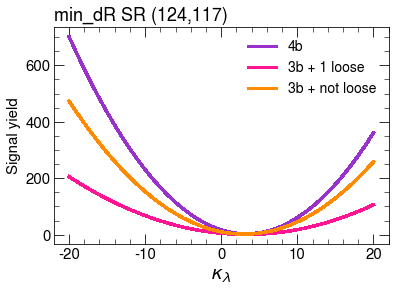

In [20]:
plt.plot(kls,s_4b,'darkorchid',label='4b')
plt.plot(kls,s_1l,'deeppink',label='3b + 1 loose')
plt.plot(kls,s_nl,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('Signal yield')
plt.legend()
plt.title('min_dR SR (124,117)',loc='left')




In [21]:
b_sr_4b = np.sum(b_4b.loc[ (b_4b.ntag == 2) & (b_4b.kr_new ==0),'w_2b'])
b_sr_1l = np.sum(b_1l.loc[ (b_1l.ntag == 2) & (b_1l.kr_new ==0),'w_2b'])
b_sr_nl = np.sum(b_nl.loc[ (b_nl.ntag == 2) & (b_nl.kr_new ==0),'w_2b'])


b_vr_4b = np.sum(b_4b.loc[ (b_4b.ntag == 2) & (b_4b.kr_new ==1),'w_2b'])
b_vr_1l = np.sum(b_1l.loc[ (b_1l.ntag == 2) & (b_1l.kr_new ==1),'w_2b'])
b_vr_nl = np.sum(b_nl.loc[ (b_nl.ntag == 2) & (b_nl.kr_new ==1),'w_2b'])



<ipython-input-22-1cc3466e457c>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverB_kl.pdf',bbox_to_anchor='tight')


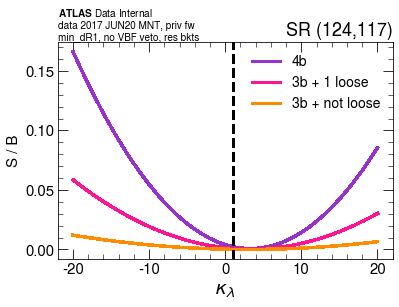

In [22]:
soverb_4b = s_4b / b_sr_4b
soverb_1l = s_1l / b_sr_1l
soverb_nl = s_nl / b_sr_nl

plt.plot(kls,soverb_4b,'darkorchid',label='4b')
plt.plot(kls,soverb_1l,'deeppink',label='3b + 1 loose')
plt.plot(kls,soverb_nl,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('S / B')
plt.legend()
plt.title('SR (124,117)',loc='right')

ylim = plt.ylim()
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'{figDir}/sOverB_kl.pdf',bbox_to_anchor='tight')

In [23]:
soverb_vr_4b = s_vr_4b / b_vr_4b
soverb_vr_1l = s_vr_1l / b_vr_1l
soverb_vr_nl = s_vr_nl / b_vr_nl

In [24]:
soverSqrtb_4b = s_4b / np.sqrt(b_sr_4b)
soverSqrtb_1l = s_1l / np.sqrt(b_sr_1l)
soverSqrtb_nl = s_nl / np.sqrt(b_sr_nl)

In [25]:
soverSqrtb_vr_4b = s_vr_4b / np.sqrt(b_vr_4b)
soverSqrtb_vr_1l = s_vr_1l / np.sqrt(b_vr_1l)
soverSqrtb_vr_nl = s_vr_nl / np.sqrt(b_vr_nl)

In [26]:
np.min(b_4b.X_wt)

1.500017071940794

In [27]:
np.max(b_4b.ntag)

6.0

In [28]:
np.sum(b_4b.loc[b_4b.kr_new ==1,'w_2b']) / np.sum(b_4b.loc[b_4b.kr_new ==0,'w_2b'])

1.327071227725819

In [29]:
b_vr_4b = np.sum(b_4b.loc[b_4b.kr_new ==1,'w_2b']) 
b_sr_4b = np.sum(b_4b.loc[b_4b.kr_new ==0,'w_2b'])

Text(0, 0.5, 'VR / SR')

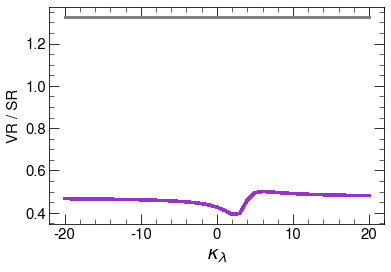

In [30]:
plt.plot(kls,s_vr_4b / s_4b,'darkorchid',label='sig')
plt.plot(kls,np.ones_like(kls)* b_vr_4b / b_sr_4b,'grey')
plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('VR / SR')

<ipython-input-31-35b030f1d544>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverB_by4b_kl.pdf',bbox_to_anchor='tight')


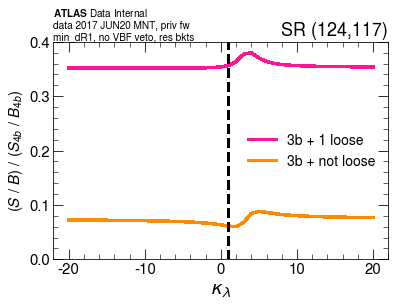

In [31]:
plt.plot(kls,soverb_1l/soverb_4b,'deeppink',label='3b + 1 loose')
plt.plot(kls,soverb_nl/soverb_4b,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('($S$ / $B$) / ($S_{4b}$ / $B_{4b}$)')
plt.legend()
plt.title('SR (124,117)',loc='right')

ylim = [0,.4]
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'{figDir}/sOverB_by4b_kl.pdf',bbox_to_anchor='tight')

In [32]:
kls[21],kls[30],

(1, 10)

In [33]:
soverb_4b[21]

0.002295402742288506

In [34]:
soverb_vr_4b[21] / soverb_4b[21]

0.31360597135323465

In [35]:
soverb_vr_4b[30] / soverb_4b[30]

0.3738985300271576

**Yes** this is hella consistent w/ Sean :D (despite all the caveats lol)

<ipython-input-36-6bdedde14f0c>:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverSqrtB_inc_vr_kl.pdf',bbox_to_anchor='tight')


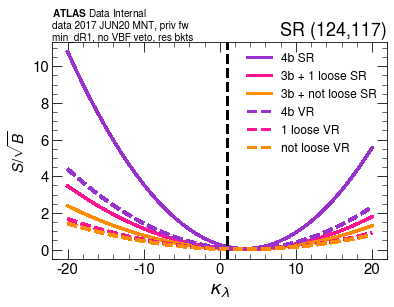

In [36]:
plt.plot(kls,soverSqrtb_4b,'darkorchid',label='4b SR')
plt.plot(kls,soverSqrtb_1l,'deeppink',label='3b + 1 loose SR')
plt.plot(kls,soverSqrtb_nl,'darkorange',label='3b + not loose SR')


plt.plot(kls,soverSqrtb_vr_4b,'darkorchid',label='4b VR',ls='--')
plt.plot(kls,soverSqrtb_vr_1l,'deeppink',label='1 loose VR',ls='--')
plt.plot(kls,soverSqrtb_vr_nl,'darkorange',label='not loose VR',ls='--')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('$S / \sqrt{B}$')
plt.legend(loc='upper right',fontsize=12)
plt.title('SR (124,117)',loc='right')

ylim = plt.ylim()
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'{figDir}/sOverSqrtB_inc_vr_kl.pdf',bbox_to_anchor='tight')

<ipython-input-37-5ce38ae95ade>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverB_by4b_vrContam_kl.pdf',bbox_to_anchor='tight')


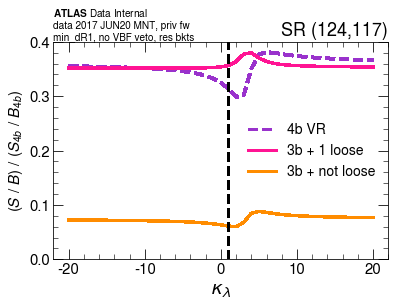

In [37]:
plt.plot(kls,soverb_vr_4b/soverb_4b,'darkorchid',ls='--',label='4b VR')
plt.plot(kls,soverb_1l/soverb_4b,'deeppink',label='3b + 1 loose')
plt.plot(kls,soverb_nl/soverb_4b,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('($S$ / $B$) / ($S_{4b}$ / $B_{4b}$)')
plt.legend()
plt.title('SR (124,117)',loc='right')

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

ylim = [0,.4]
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

plt.savefig(f'{figDir}/sOverB_by4b_vrContam_kl.pdf',bbox_to_anchor='tight')

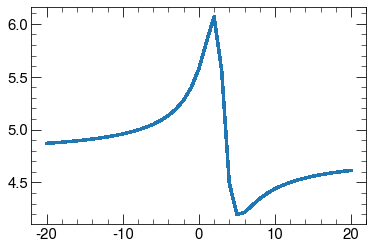

In [84]:
plt.plot(kls,soverb_1l/soverb_nl)

<ipython-input-38-0f6754599177>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverSqrtB_inc_by4b_vrContam_kl.pdf',bbox_to_anchor='tight')


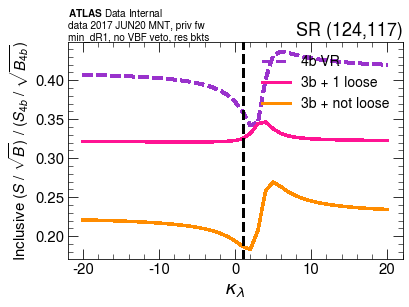

In [38]:
plt.plot(kls,soverSqrtb_vr_4b/soverSqrtb_4b,'darkorchid',ls='--',label='4b VR')
plt.plot(kls,soverSqrtb_1l/soverSqrtb_4b,'deeppink',label='3b + 1 loose')
plt.plot(kls,soverSqrtb_nl/soverSqrtb_4b,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('Inclusive ($S$ / $\sqrt{B}$) / ($S_{4b}$ / $\sqrt{B_{4b}}$)')
plt.legend()
plt.title('SR (124,117)',loc='right')

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

ylim = plt.ylim() #[0,.4]
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

plt.savefig(f'{figDir}/sOverSqrtB_inc_by4b_vrContam_kl.pdf',bbox_to_anchor='tight')

<ipython-input-39-1cc3466e457c>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{figDir}/sOverB_kl.pdf',bbox_to_anchor='tight')


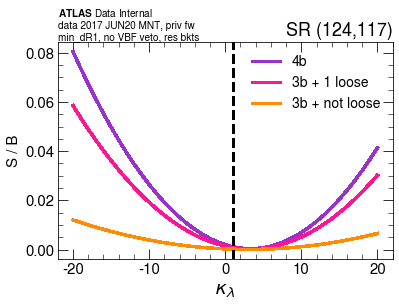

In [39]:
soverb_4b = s_4b / b_sr_4b
soverb_1l = s_1l / b_sr_1l
soverb_nl = s_nl / b_sr_nl

plt.plot(kls,soverb_4b,'darkorchid',label='4b')
plt.plot(kls,soverb_1l,'deeppink',label='3b + 1 loose')
plt.plot(kls,soverb_nl,'darkorange',label='3b + not loose')

plt.xlabel('$\kappa_\lambda$',fontsize=20)
plt.ylabel('S / B')
plt.legend()
plt.title('SR (124,117)',loc='right')

ylim = plt.ylim()
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

ax = plt.gca()
ax.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax.transAxes)

plt.savefig(f'{figDir}/sOverB_kl.pdf',bbox_to_anchor='tight')

Hmmmmmmm ok, something is not *quite* matching up rn.

From Sean's talk, I should expect: 
- 31% VR contam for SM
- 37% contam for $\kappa_\lambda = 10$

**Plan:** Make (and save) the s and b histograms.


1. Let's *overlay* all of the signal hists
2. And then, let's *overlay* all of the background hists

In [40]:
hists = {}

<ipython-input-82-01844cd509ca>:19: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f's_sr_1l']/hists[f's_sr_4b'],'deeppink',marker='o',lw=0)
<ipython-input-82-01844cd509ca>:20: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f's_sr_nl']/hists[f's_sr_4b'],'darkorange',marker='o',lw=0)


1l 0.29591023435038727
nl 0.570488663924774


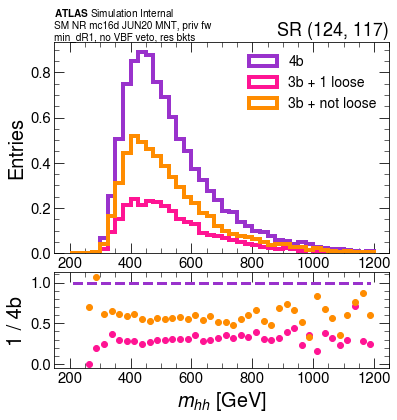

In [82]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

for si,c,l,li in zip([sdf.ntag>=4, sdf.minQ==2, sdf.minQ==1],
                     ['darkorchid','deeppink','darkorange'],
                     ['4b','3b + 1 loose','3b + not loose'],
                     ['4b','1l','nl']):
    
    smask = si & (sdf.kr_new == 0)
    n,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],40,(200,1200),weights=sdf.loc[smask,'mc_sf'],
                     color=c,histtype='step',lw=4,label=l)

    hists[f's_sr_{li}'] = n
    
# Overlay the new histos
xx = 0.5 * (e[1:]+e[:-1])
ax2.plot(xx,hists[f's_sr_1l']/hists[f's_sr_4b'],'deeppink',marker='o',lw=0)
ax2.plot(xx,hists[f's_sr_nl']/hists[f's_sr_4b'],'darkorange',marker='o',lw=0)
ax2.plot(xx,np.ones_like(xx),'darkorchid',ls='--')
    
print('1l',np.sum(hists[f's_sr_1l'])/np.sum(hists[f's_sr_4b']))   
print('nl',np.sum(hists[f's_sr_nl'])/np.sum(hists[f's_sr_4b'])) 

ax1.legend()
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=20)
ax1.set_ylabel('Entries',fontsize=20)
ax2.set_ylabel('1 / 4b',fontsize=20)

ax1.set_title('SR (124, 117)',loc='right')
ax1.text(0,1,smText,ha='left',va='bottom',fontsize=10,transform=ax1.transAxes)

plt.savefig(f'{figDir}/m_hh_SR_SM.pdf',bbox_inches='tight')

<ipython-input-81-2211fdec6e3d>:19: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f's_sr_1l']/hists[f's_sr_4b'],'deeppink',marker='o',lw=0)
<ipython-input-81-2211fdec6e3d>:20: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f's_sr_nl']/hists[f's_sr_4b'],'darkorange',marker='o',lw=0)


1l 0.29591023435038727
nl 0.570488663924774


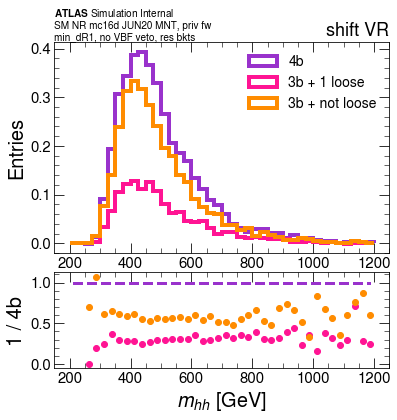

In [81]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

for si,c,l,li in zip([sdf.ntag>=4, sdf.minQ==2, sdf.minQ==1],
                     ['darkorchid','deeppink','darkorange'],
                     ['4b','3b + 1 loose','3b + not loose'],
                     ['4b','1l','nl']):
    
    smask = si & (sdf.kr_new == 1)
    n,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],40,(200,1200),weights=sdf.loc[smask,'mc_sf'],
                     color=c,histtype='step',lw=4,label=l)

    hists[f's_vr_{li}'] = n
    
# Overlay the new histos
xx = 0.5 * (e[1:]+e[:-1])
ax2.plot(xx,hists[f's_sr_1l']/hists[f's_sr_4b'],'deeppink',marker='o',lw=0)
ax2.plot(xx,hists[f's_sr_nl']/hists[f's_sr_4b'],'darkorange',marker='o',lw=0)
ax2.plot(xx,np.ones_like(xx),'darkorchid',ls='--')
    
ax1.legend()
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=20)
ax1.set_ylabel('Entries',fontsize=20)
ax2.set_ylabel('1 / 4b',fontsize=20)

ax1.set_title('shift VR',loc='right')
ax1.text(0,1,smText,ha='left',va='bottom',fontsize=10,transform=ax1.transAxes)

plt.savefig(f'{figDir}/m_hh_VR_SM.pdf',bbox_inches='tight')

In [80]:
np.sum(bdf.loc[(bdf.ntag==2) & (bdf.kr_new == 0),'w_2b']) / np.sum(b_4b.loc[(b_4b.ntag==2) & (b_4b.kr_new == 0),'w_2b'])

39397.89027468646

1l 0.8317412008503894
nl 9.328400666886298


<ipython-input-83-74a78525e460>:18: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f'b_sr_1l']/hists[f'b_sr_4b'],'deeppink',marker='o',lw=0)
<ipython-input-83-74a78525e460>:19: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,hists[f'b_sr_nl']/hists[f'b_sr_4b'],'darkorange',marker='o',lw=0)


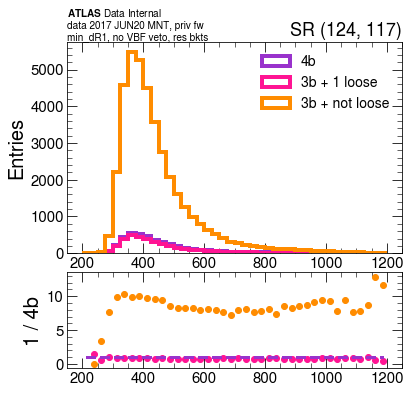

In [83]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

for bdf,c,l,li in zip([b_4b,b_1l,b_nl],['darkorchid','deeppink','darkorange'],
                      ['4b','3b + 1 loose','3b + not loose'],['4b','1l','nl']):
    
    bmask = (bdf.ntag==2) & (bdf.kr_new == 0)
    n = ax1.hist(bdf.loc[bmask,'m_hh'],40,(200,1200),weights=bdf.loc[bmask,'w_2b'],
             color=c,histtype='step',lw=4,label=l)[0]
    
    hists[f'b_sr_{li}'] = n

print('1l',np.sum(hists[f'b_sr_1l'])/np.sum(hists[f'b_sr_4b']))   
print('nl',np.sum(hists[f'b_sr_nl'])/np.sum(hists[f'b_sr_4b'])) 
    
ax2.plot(xx,hists[f'b_sr_1l']/hists[f'b_sr_4b'],'deeppink',marker='o',lw=0)
ax2.plot(xx,hists[f'b_sr_nl']/hists[f'b_sr_4b'],'darkorange',marker='o',lw=0)
ax2.plot(xx,np.ones_like(xx),'darkorchid',ls='--')
    
ax1.legend()
ax1.set_xlabel('$m_{hh}$ [GeV]',fontsize=20)
ax1.set_ylabel('Entries',fontsize=20)
ax2.set_ylabel('1 / 4b',fontsize=20)
ax1.set_title('SR (124, 117)',loc='right')

ax1.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax1.transAxes)

plt.savefig(f'{figDir}/m_hh_SR_rw_2b.pdf',bbox_inches='tight')

**Some sanity check plots in the VR?**

<ipython-input-44-297370a71b32>:28: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1-1/np.sqrt(n_4b),1+1/np.sqrt(n_4b),color='grey',alpha=0.5,step='mid')
<ipython-input-44-297370a71b32>:29: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_cr/n_4b,color='navy',marker='o',lw=0)
<ipython-input-44-297370a71b32>:30: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_vr/n_4b,color='darkorange',marker='o',lw=0)


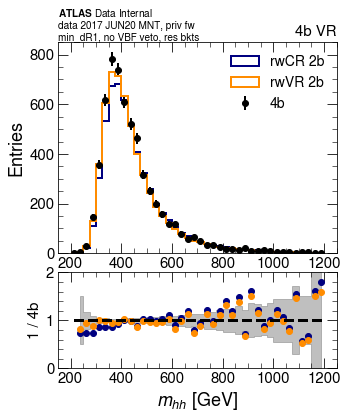

<ipython-input-44-297370a71b32>:28: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1-1/np.sqrt(n_4b),1+1/np.sqrt(n_4b),color='grey',alpha=0.5,step='mid')
<ipython-input-44-297370a71b32>:29: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(xx,rw_cr/n_4b,color='navy',marker='o',lw=0)
<ipython-input-44-297370a71b32>:29: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_cr/n_4b,color='navy',marker='o',lw=0)
<ipython-input-44-297370a71b32>:30: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(xx,rw_vr/n_4b,color='darkorange',marker='o',lw=0)
<ipython-input-44-297370a71b32>:30: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_vr/n_4b,color='darkorange',marker='o',lw=0)


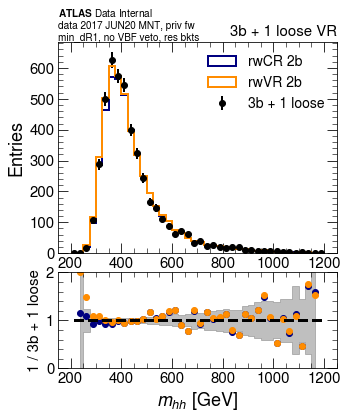

<ipython-input-44-297370a71b32>:28: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(xx,1-1/np.sqrt(n_4b),1+1/np.sqrt(n_4b),color='grey',alpha=0.5,step='mid')
<ipython-input-44-297370a71b32>:29: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_cr/n_4b,color='navy',marker='o',lw=0)
<ipython-input-44-297370a71b32>:30: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,rw_vr/n_4b,color='darkorange',marker='o',lw=0)


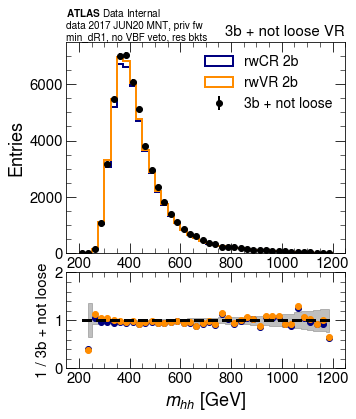

In [44]:
for bdf,c,l,li,mi in zip([b_4b,b_1l,b_nl],['darkorchid','deeppink','darkorange'],
                         ['4b','3b + 1 loose','3b + not loose'],['4b','1l','nl'],
                         [b_4b.ntag>=4, (b_1l.ntag==3) & (b_1l.minQ==2), (b_nl.ntag==3) & (b_nl.minQ==1)]):
    
    fig = plt.figure(figsize=(5,6))
    gs = gridspec.GridSpec(3,1)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

    m_2b = (bdf.ntag ==2)& (bdf.kr_new ==1)
    rw_cr = ax1.hist(bdf.loc[m_2b,'m_hh'],40,(200,1200), weights=bdf.loc[m_2b,'w_2b'],
             histtype='step',lw=2,color='navy',label='rwCR 2b')[0]
    
    rw_vr = ax1.hist(bdf.loc[m_2b,'m_hh'],40,(200,1200),weights=bdf.loc[m_2b,'w_2b_VR'],
             histtype='step',lw=2,color='darkorange',label='rwVR 2b')[0]

    
    hists[f'b_vr_{li}'] = rw_cr
    
    n_4b,e = np.histogram(bdf.loc[mi& (bdf.kr_new ==1),'m_hh'],40,(200,1200))

    xx = 0.5 * (e[1:] + e[:-1])

    ax1.errorbar(xx,n_4b,np.sqrt(n_4b),color='k',lw=0,marker='o',elinewidth=2,
                 label=l)
    
    
    ax2.fill_between(xx,1-1/np.sqrt(n_4b),1+1/np.sqrt(n_4b),color='grey',alpha=0.5,step='mid')
    ax2.plot(xx,rw_cr/n_4b,color='navy',marker='o',lw=0)
    ax2.plot(xx,rw_vr/n_4b,color='darkorange',marker='o',lw=0)
    ax2.plot(xx,np.ones_like(xx),'k--')
    
    ax1.legend()
    ax1.set_title(f'{l} VR',loc='right',fontsize=15)
    ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    ax1.set_ylabel('Entries',fontsize=18)
    
    ax2.set_ylabel(f'1 / {l}')
    ax2.set_ylim(0,2)
    
    ax1.text(0,1,text,ha='left',va='bottom',fontsize=10,transform=ax1.transAxes)
    
    plt.savefig(f'{figDir}/m_hh_VR_rw_2b_{li}.pdf',bbox_inches='tight')
    plt.show()

## $S / \sqrt{B}$

- First just plot $S / \sqrt{B}$
- Get signal histos for each kl point

<ipython-input-45-d16bf4d1d488>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_sr_{li}'] = si / np.sqrt(bi)
<ipython-input-45-d16bf4d1d488>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l)
<ipython-input-45-d16bf4d1d488>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_sr_{li}'] = si / np.sqrt(bi)
<ipython-input-45-d16bf4d1d488>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l)
<ipython-input-45-d16bf4d1d488>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_sr_{li}'] = si / np.sqrt(bi)
<ipython-input-45-d16bf4d1d488>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l)
<ipython-input-45-d16bf4d1d488>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),'darkorchid',marker='o',lw=1,ls='--

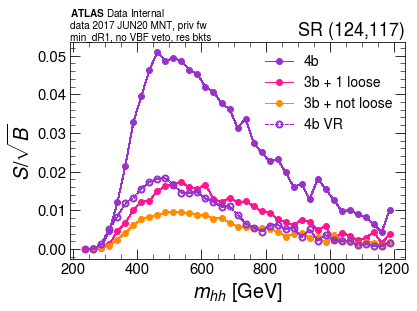

In [45]:
for c,l,li in zip(['darkorchid','deeppink','darkorange'],
                  ['4b','3b + 1 loose','3b + not loose'],['4b','1l','nl']):

    si = hists[f's_sr_{li}']
    bi = hists[f'b_sr_{li}']
    
    hists[f'z_sr_{li}'] = si / np.sqrt(bi)
    
    plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l)
    
si = hists[f's_vr_4b']
bi = hists[f'b_vr_4b']

plt.plot(xx,si/np.sqrt(bi),'darkorchid',marker='o',lw=1,ls='--',label='4b VR',
         markerfacecolor="None",markeredgecolor='darkorchid', markeredgewidth=2)

plt.xlabel('$m_{hh}$ [GeV]',fontsize=20)
plt.ylabel('$S / \sqrt{B}$',fontsize=20)
plt.legend()

ax = plt.gca()
plt.title('SR (124,117)',loc='right')
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/sOverSqrtB_m_hh_SR_sm.pdf',bbox_inches='tight')

<ipython-input-46-e4c91fe1056d>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_vr_{li}'] = si / np.sqrt(bi)
<ipython-input-46-e4c91fe1056d>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l,ls='--',
<ipython-input-46-e4c91fe1056d>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_vr_{li}'] = si / np.sqrt(bi)
<ipython-input-46-e4c91fe1056d>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l,ls='--',
<ipython-input-46-e4c91fe1056d>:7: RuntimeWarning: invalid value encountered in true_divide
  hists[f'z_vr_{li}'] = si / np.sqrt(bi)
<ipython-input-46-e4c91fe1056d>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l,ls='--',


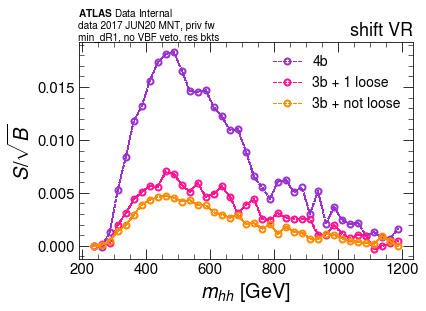

In [46]:
for c,l,li in zip(['darkorchid','deeppink','darkorange'],
                  ['4b','3b + 1 loose','3b + not loose'],['4b','1l','nl']):

    si = hists[f's_vr_{li}']
    bi = hists[f'b_vr_{li}']
    
    hists[f'z_vr_{li}'] = si / np.sqrt(bi)
    
    plt.plot(xx,si/np.sqrt(bi),c,marker='o',lw=1,label=l,ls='--',
             markerfacecolor="None",markeredgecolor=c, markeredgewidth=2)
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=20)
plt.ylabel('$S / \sqrt{B}$',fontsize=20)
plt.legend()

ax = plt.gca()
plt.title('shift VR',loc='right')
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/sOverSqrtB_m_hh_VR_sm.pdf',bbox_inches='tight')

In [47]:
sig = pd.DataFrame(0,['sr','vr'],['4b','3b + 1 loose','3b + not loose'])

In [48]:
for i in ['sr','vr'] :
    for l, li in zip(['4b','3b + 1 loose','3b + not loose'],['4b','1l','nl']):

        sig.loc[i,l] = np.sqrt(np.sum(np.nan_to_num(hists[f'z_{i}_{li}'])**2))

In [49]:
sig.round(4)

4b  3b + 1 loose  3b + not loose
sr  0.1799        0.0617          0.0349
vr  0.0589        0.0226          0.0155

In [50]:
z_kl = pd.DataFrame(0,kl_cols,['4b','1l','nl','4b vr'])

In [67]:
for kl in kl_cols:
    
    # Get the signal histogram
    for smask, li in zip([sdf.ntag>=4, sdf.minQ==2, sdf.minQ==1],['4b','1l','nl']):
        si = np.histogram(sdf.loc[smask & (sdf.kr_new==0),'m_hh'],40,(200,1200),
                          weights=sdf.loc[smask & (sdf.kr_new==0),kl])[0]
        #print(kl,li,si)
        zi = si / np.sqrt(hists[f'b_sr_{li}'])
        z_kl.loc[kl,li] = np.sqrt(np.sum(np.nan_to_num(zi)**2))
        
        
    # 4b VR
    smask = (sdf.ntag>=4) & (sdf.kr_new == 1)
    si = np.histogram(sdf.loc[smask,'m_hh'],40,(200,1200), weights=sdf.loc[smask,kl])[0]
        
    zi = si / np.sqrt(hists[f'b_vr_4b'])
    z_kl.loc[kl,'4b vr'] = np.sqrt(np.sum(np.nan_to_num(zi)**2))

<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:16: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_vr_4b'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:16: RuntimeWarning: invalid value enco

<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:16: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_vr_4b'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:16: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_vr_4b'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encountered in true_divide
  zi = si / np.sqrt(hists[f'b_sr_{li}'])
<ipython-input-67-bc6e062ea64f>:8: RuntimeWarning: invalid value encoun

Text(0, 0.5, 'Quad sum $S/\\sqrt{B}$')

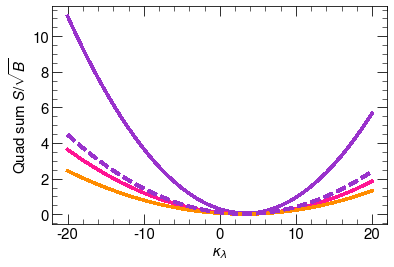

In [68]:
plt.plot(kls,z_kl['4b'],'darkorchid')
plt.plot(kls,z_kl['1l'],'deeppink')
plt.plot(kls,z_kl['nl'],'darkorange')
plt.plot(kls,z_kl['4b vr'],'darkorchid',ls='--')

plt.xlabel('$\kappa_\lambda$')
plt.ylabel('Quad sum $S/\sqrt{B}$')

In [69]:
sig.round(4)

4b  3b + 1 loose  3b + not loose
sr  0.1799        0.0617          0.0349
vr  0.0589        0.0226          0.0155

In [78]:
np.sqrt(sig.loc['sr','4b']**2+sig.loc['sr','3b + 1 loose']**2)/sig.loc['sr','4b']

1.0571914452743476

In [79]:
np.sqrt(np.sum(sig.loc['sr']**2))/sig.loc['sr','4b']

1.0748388027752362

In [70]:
kls[21]

1

In [71]:
z_kl['1l'][21]

0.0617188631757704

In [72]:
z_kl['nl'][21]

0.034902099331835634

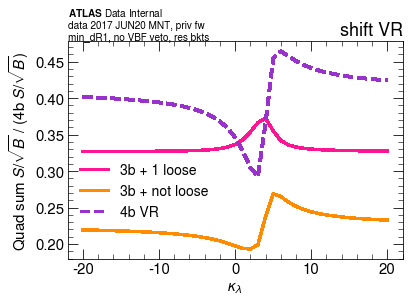

In [73]:
plt.plot(kls,z_kl['1l']/z_kl['4b'],'deeppink',label='3b + 1 loose')
plt.plot(kls,z_kl['nl']/z_kl['4b'],'darkorange',label='3b + not loose')
plt.plot(kls,z_kl['4b vr']/z_kl['4b'],'darkorchid',ls='--',label='4b VR')
plt.xlabel('$\kappa_\lambda$')
plt.ylabel('Quad sum $S/\sqrt{B}$ / (4b $S/\sqrt{B}$)')

plt.legend(loc='upper left',bbox_to_anchor=(0,.5))

ax = plt.gca()
plt.title('SR (124 )',loc='right')
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/sig_quadSum_by_4b_sm.pdf',bbox_inches='tight')